<h1>Deep learning project 8DM20 CSMIA</h1>

<h4>Group members:</h4>
O. Akdag - 0842508 <br>
T.P.A. Beishuizen - 0791613 <br>
A.S.A. Eskelinen - 1224333 <br>
J.H.A. Migchielsen - 0495058 <br>
L. van den Wildenberg - 0844697 <br>

In [2]:
# Import all used packages (unused packages are commented out so far)
import os
from PIL import Image as PIL_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.feature_extraction import image as sklearn_image
#matplotlib inline
import theano
import lasagne
import time
import random
import math
random.seed(0)

C:\Users\s119104\AppData\Local\Continuum\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


<h4>Preprocessing</h4>

Before every thing can be done, at first the data images have to be read and be made in useable data types.

In [54]:
# The function that loads the data
def loadData(data_set = 'test', image = '1st_manual'):
    
    # Check for the correct input
    if data_set != 'test' and data_set != 'training':
        raise Exception('Not the right data_set file')
    if image != '1st_manual' and image != '2nd_manual' and image != 'images' and image != 'mask':
        raise Exception('Not the right image file')
    if data_set == 'training' and image == '2nd_manual':
        raise Exception('File not available')
    
    # Project and image path
    project_path = os.getcwd()
    images_path = project_path +  '/8DM20_image_dataset/' + data_set + '/' + image + '/'
    
    images = []
    
    #Open image for image (20 in total for each of them)
    for i in range(1, 21):
        
        # Find correct image number
        image_nr = str(i)
        if data_set == 'training':
            image_nr = str(20 + i)
        elif len(image_nr) == 1:
            image_nr = '0' + image_nr
            
        # Specify path for this image
        if image == '1st_manual':
            image_path = images_path + image_nr + '_manual1.gif'
        elif image == '2nd_manual':
            image_path = images_path + image_nr + '_manual2.gif'
        elif image == 'images':
            image_path = images_path + image_nr + '_' + data_set + '.tif'
        elif image == 'mask':
            image_path = images_path + image_nr + '_' + data_set + '_mask.gif'
        
        # Open and append the image to the image list
        images.append(PIL_image.open(image_path))
        
    return images

#The function that converts the channels in the images from RGB to gray
#and makes matrices from the images
def convertImageToMatrix(images):
    
    image_matrices = []
    
    for image in images:
        image_matrix = np.asarray(image.convert('L'))
        image_matrices.append(image_matrix)
        
    return image_matrices

#The function that prepares the image matrices to the data used for machine learning
def prepareMachineLearningData(image_matrix, output_matrix, mask_matrix, kernel_size, mask_removal = 'pixel'):
    #Check if correct input
    if not (isinstance(image_matrix, np.ndarray) and 
            isinstance(output_matrix, np.ndarray) and 
            isinstance(mask_matrix, np.ndarray)):
        raise Exception("Not all input matrices are numpy matrices")
    
    if mask_removal != 'pixel' and mask_removal != 'patch':
        raise Exception("Unknown mask data removal type")
    
    if not (image_matrix.shape == output_matrix.shape == mask_matrix.shape):
        raise Exception("The images are not the same size")
    
    if np.unique(mask_matrix).shape[0] != 2:
        raise Exception("The mask matrix does not consist of only 2 values")
    
    #Creates a matrix with all possible patches
    all_image_patches = sklearn_image.extract_patches_2d(image_matrix,(kernel_size,kernel_size))
    all_image_patches = np.expand_dims(all_image_patches, axis=1)
    
    if kernel_size % 2 != 0:
         # Creates an array with all output
        mat_red = (kernel_size - 1) / 2
        reduced_output_matrix = output_matrix[ mat_red : -  mat_red,  mat_red : -  mat_red]
        complete_output_array = reduced_output_matrix.reshape(-1)

        new_mask_matrix = mask_matrix.copy()
        
        # Makes some additional mask values zero on the edge of the mask
        if mask_removal == 'patch':
            for i in range(mat_red, mask_matrix.shape[0] -  mat_red + 1):
                for j in range(mat_red, mask_matrix.shape[1] -  mat_red + 1):
                    if 0 in mask_matrix[i - mat_red : i + mat_red + 1, j - mat_red: j + mat_red + 1]:
                        new_mask_matrix[i,j] = 0;
        
        # Creates an array with all mask locations
        reduced_mask_matrix = new_mask_matrix[ mat_red : -  mat_red, mat_red : -  mat_red]
        mask_array = reduced_mask_matrix.reshape(-1)
    
    else:
        # Creates an array with all output
        mat_red = (kernel_size) / 2
        reduced_output_matrix = output_matrix[mat_red - 1: -  mat_red,  mat_red - 1: -  mat_red]
        complete_output_array = reduced_output_matrix.reshape(-1)

        new_mask_matrix = mask_matrix.copy()
        
        # Makes some additional mask values zero on the edge of the mask
        if mask_removal == 'patch':
            for i in range(mat_red - 1, mask_matrix.shape[0] -  mat_red - 1):
                for j in range(mat_red - 1, mask_matrix.shape[1] -  mat_red - 1):
                    if 0 in mask_matrix[i - mat_red + 1 : i + mat_red + 1, j - mat_red + 1: j + mat_red + 1]:
                        new_mask_matrix[i,j] = 0;
                     
        # Creates an array with all mask locations
        reduced_mask_matrix = new_mask_matrix[mat_red - 1: - mat_red, mat_red - 1: - mat_red]
        mask_array = reduced_mask_matrix.reshape(-1) 

    image_patches = []
    output_array = []    
    
    # Reduces the number of patches and output to only the mask values
    for i in range(len(mask_array)):
        if mask_array[i] != 0:
            image_patches.append(all_image_patches[i,:,:])
            output_array.append(complete_output_array[i])
    
    # Return the image patches and the output array
    return image_patches, output_array

# Prepare multiple images at once
def prepareMultipleImages(image_matrices, output_matrices, mask_matrices, kernel_size = 25, mask_removal = 'pixel'):
    #Check if correct input
    if not (isinstance(image_matrices, list) and 
            isinstance(output_matrices, list) and 
            isinstance(mask_matrices, list)):
        raise Exception("Not all input matrices are numpy matrices")
    
    if not (len(image_matrices) == len(output_matrices) == len(mask_matrices)):
        raise Exception("The images are not the same size")
    
    image_patches = [] 
    output_arrays = []
    
    # Finds the output data per image
    for i in range(len(image_matrices)):
        new_image_patches, new_output_array = prepareMachineLearningData(image_matrices[i], output_matrices[i], mask_matrices[i], 
                                                                         kernel_size = kernel_size, mask_removal = mask_removal)
        image_patches.append(new_image_patches)
        output_arrays.append(new_output_array)
        
        #Print progress for showing time consumption
        print"Progress: {} %".format(100*(i+1)/len(image_matrices)),
              
    return image_patches, output_arrays

def createVesselImage(output_array, mask_matrix, kernel_size, mask_removal = "pixel"):
    #Check if input is correct
    if not isinstance(output_array, list) or not isinstance(mask_matrix, np.ndarray) or not isinstance(kernel_size, int):
        raise Exception("Not the right input variables")
    
    if mask_removal != "pixel" and mask_removal != 'patch':
        raise Exception("Unknown mask removal type")
    
    #Create an output_matrix for the output array
    #output_matrix = np.array(mask_matrix)
    output_matrix = np.zeros(mask_matrix.shape)
    output_loc = 0
    
    # Take into account that mask pixels too close to the border are lost due to inability to make patches
    edge_corr = int(math.ceil(kernel_size / 2) - 1)
    
    new_mask_matrix = mask_matrix.copy()
    
    # Makes some additional mask values zero on the edge of the mask
    if mask_removal == 'patch':
        for i in range(edge_corr, mask_matrix.shape[0] - edge_corr - 2):
            for j in range(edge_corr, mask_matrix.shape[1] - edge_corr - 2):
                if 0 in mask_matrix[i - edge_corr  : i + edge_corr + 2, j - edge_corr: j + edge_corr + 2]:
                    new_mask_matrix[i,j] = 0;
       
    # Check every pixel within the mask for a vessel pixel
    for i in range(mask_matrix.shape[0] - kernel_size + 1):
        for j in range(mask_matrix.shape[1] - kernel_size + 1):
            if new_mask_matrix[i + edge_corr, j + edge_corr] == 255:
                output_matrix[i + edge_corr, j + edge_corr] = output_array[output_loc]
                output_loc += 1
                
    return output_matrix 

All images are loaded and immediately made into matrices for further computation

In [39]:
# All test image lists
test_manual1_images = loadData('test', '1st_manual')
test_manual2_images = loadData('test', '2nd_manual')
test_raw_images = loadData('test', 'images')
test_mask_images = loadData('test', 'mask')

# Making matrices of the test images to work with
test_manual1_matrices = convertImageToMatrix(test_manual1_images)
test_manual2_matrices = convertImageToMatrix(test_manual2_images)
test_raw_matrices = convertImageToMatrix(test_raw_images)
test_mask_matrices = convertImageToMatrix(test_mask_images)

# All training image lists
training_manual1_images = loadData('training', '1st_manual')
training_raw_images = loadData('training', 'images')
training_mask_images = loadData('training', 'mask')

# Making matrices of the training images to work with
training_manual1_matrices = convertImageToMatrix(training_manual1_images)
training_raw_matrices = convertImageToMatrix(training_raw_images)
training_mask_matrices = convertImageToMatrix(training_mask_images)

The matrices are then used for further preprocessing to retrieve the suitable data for machine learning

In [52]:
#Choose the number of images
nr_images_training = 2
nr_images_test = 1

# Prepares the data for machine learning: X = image_patches, y = output_array
# Both are a list with the patches and output_arrays for multiple images (the number chosen before)
image_patches, output_array = prepareMultipleImages(training_raw_matrices[0:nr_images_training], training_manual1_matrices[0:nr_images_training], 
                                                     training_mask_matrices[0:nr_images_training], 32, mask_removal = 'patch')
test_image_patches, test_output_array = prepareMultipleImages(test_raw_matrices[0:nr_images_test], test_manual1_matrices[0:nr_images_test], 
                                                     test_mask_matrices[0:nr_images_test], 32, mask_removal = 'patch')

Number of good patches according to mask array is 193342
Length output array is 193342
Progress: 50 % Number of good patches according to mask array is 195382
Length output array is 195382
Progress: 100 % Number of good patches according to mask array is 192286
Length output array is 192286
Progress: 100 %


<h4>Algorithm setup</h4>
The following algorithms are to show how the data set is built up. There are patches of 32x 32. These values either correspond to a vene pixel or not.

In [50]:
def train_and_validation_set(image_patches, output_array):
    all_train_patches = []
    all_train_output = []

    for i in range(nr_images_training):
        if i <= (nr_images_training-1)/2 :
            for j in range(len(image_patches[i])):
                all_train_patches.append(image_patches[i][j])
                all_train_output.append(output_array[i][j])
        else:
            valid_patches = image_patches[i]
            valid_output = output_array[i]
    
    return all_train_patches, all_train_output, valid_patches, valid_output

def hot_encoding(all_train_output, valid_output):
    train_hot_output = np.zeros((len(all_train_output),2),dtype=np.int16)

    # Make hot encoding training set
    for i in range(len(train_hot_output)):
        if all_train_output[i] == 0:
            train_hot_output[i,0] = 1
        else:
            train_hot_output[i,1] = 1      

    # Make hot encoding validation set
    valid_hot_output = np.zeros((len(valid_output),2),dtype=np.int16)

    for i in range(len(valid_hot_output)):
        if valid_output[i] == 0:
            valid_hot_output[i,0] = 1
        else:
            valid_hot_output[i,1] = 1
    
    return train_hot_output, valid_hot_output


def test_set(test_image_patches, test_output_array):
    all_test_patches = []
    all_test_output_array = []
    
    for i in range(nr_images_test):
        for j in range(len(test_image_patches[i])):
            all_test_patches.append(test_image_patches[i][j])
            all_test_output_array.append(test_output_array[i][j])
                
    return all_test_patches, all_test_output_array

Important to first make the output array. This is done with hot encoding

In [53]:
all_train_patches, all_train_output, valid_patches, valid_output = train_and_validation_set(image_patches, output_array)
train_hot_output, valid_hot_output = hot_encoding(all_train_output, valid_output)

all_test_patches, all_test_output_array = test_set(test_image_patches, test_output_array)

Build the LeNet network

In [132]:
def buildLeNet(X1):
    inputlayer = lasagne.layers.InputLayer(shape=(None, 1, 32, 32),input_var=X1)    
    print inputlayer.output_shape
    
    layer1 = lasagne.layers.Conv2DLayer(inputlayer, num_filters=6, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    print layer1.output_shape 
    
    layer2 = lasagne.layers.MaxPool2DLayer(layer1, pool_size=(2, 2))
    print layer2.output_shape 
    
    layer3 = lasagne.layers.Conv2DLayer(layer2, num_filters=16, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    print layer3.output_shape 
    
    layer4 = lasagne.layers.MaxPool2DLayer(layer3, pool_size=(2, 2))
    print layer4.output_shape 
    
    layer4 = lasagne.layers.flatten(layer4)
    print layer4.output_shape 
    
    layer5 = lasagne.layers.DenseLayer(layer4,num_units=120,nonlinearity=lasagne.nonlinearities.rectify)    
    print layer5.output_shape 
    
    layer6 = lasagne.layers.DenseLayer(layer5,num_units=84,nonlinearity=lasagne.nonlinearities.rectify)
    print layer6.output_shape 
    
    outputlayer = lasagne.layers.DenseLayer(layer6,num_units=2,nonlinearity=lasagne.nonlinearities.softmax)     
    print outputlayer.output_shape 
    
    return layer1, layer2, layer3, layer4, layer5, layer6, outputlayer

In [133]:
X = theano.tensor.tensor4()
Y = theano.tensor.matrix()
layer1, layer2, layer3, layer4, layer5, layer6, outputlayer = buildLeNet(X)

(None, 1, 32, 32)
(None, 6, 28, 28)
(None, 6, 14, 14)
(None, 16, 10, 10)
(None, 16, 5, 5)
(None, 400)
(None, 120)
(None, 84)
(None, 2)


Defining functions for training, validation and testing purposes for the previously made LeNet network

In [134]:
outputtrain = lasagne.layers.get_output(outputlayer) #function that gets the output from the network defined before.
trainloss = lasagne.objectives.categorical_crossentropy(outputtrain, Y).mean() #function that computes the mean crossentropy between the output and the real labels.
params = lasagne.layers.get_all_params(outputlayer, trainable=True) #function that gets all the parameters (weights) in the network.
updates = lasagne.updates.momentum(trainloss, params, learning_rate=0.001) #function that performs an update of the weights based on the loss.
train = theano.function(inputs=[X, Y], outputs=trainloss, updates=updates, allow_input_downcast=True) #function that does all the above based on training samples X and real labels Y.

validate = theano.function(inputs=[X, Y], outputs=trainloss, allow_input_downcast=True) #function that computes the loss without performing an update

outputtest = lasagne.layers.get_output(outputlayer, deterministic=True) #function that gets the output from the network defined before.
test = theano.function(inputs=[X], outputs=outputtest, allow_input_downcast=True) #function that gets the output based on input X

In [135]:
def training_the_network(all_train_output, valid_output, all_train_patches, valid_patches, minibatches = 250, minibatchsize = 100):

    trainingsamples = np.arange(len(all_train_output)) #numbers from 0 until the number of samples
    validsamples = np.arange(len(valid_output))

    losslist = []
    validlosslist = []

    t0 = time.time()

    for i in xrange(minibatches):
        print("Currently at batch %d" % i)

        # Random train sample information. IMPORTANT: Use the hot encoded labels (that's the way the algorithm works)
        random_train_patches, random_train_output = sampleBatches(all_train_patches, all_train_output, 
                                                                  batch_size = minibatchsize, distribution = 0.5)

        # Random validation sample information IMPORTANT: Use the hot encoded labels (that's the way the algorithm works)
        random_valid_patches, random_valid_output = sampleBatches(valid_patches, valid_output, 
                                                                  batch_size = minibatchsize, distribution = 0.5)

        new_train_loss = train(random_train_patches, random_train_output)
        losslist.append(new_train_loss)

        new_valid_loss = validate(random_valid_patches, random_valid_output)
        validlosslist.append(new_valid_loss)
        #select random training en validation samples and perform training and validation steps here.

    t1 = time.time()
    print 'Training time: {} seconds'.format(t1-t0)
    
    return losslist, validlosslist


# Creates bathces of vessel and non vessel images of a certain distribution
def sampleBatches(input_patches, output_array, batch_size = 100, distribution = 0.5):
    if len(input_patches) != len(output_array):
        raise Exception("Length of input and output is different")
    
    if distribution < 0 or distribution > 1:
        raise Exception("Impossible distribution")
        
    non_vessel_patches = []
    vessel_patches = []
    
    #First create two lists. One with vessel patches and one without
    for i in range(len(input_patches)):
        if output_array[i] == 0:
            non_vessel_patches.append(input_patches[i])
            
        else:
            vessel_patches.append(input_patches[i])
            
    # Choose non vessel patches for in the batch
    samples_non_vessel = np.arange(len(non_vessel_patches)) #numbers from 0 until the number of samples
    random_non_vessel_samples = random.sample(samples_non_vessel, int(batch_size * distribution))
    non_vessel_output = int(batch_size * distribution) * [[1, 0]]
    non_vessel_patches = np.asarray(non_vessel_patches)[random_non_vessel_samples]
    
    # Choose vessel patches for in the batch
    samples_vessel = np.arange(len(vessel_patches)) #numbers from 0 until the number of samples
    random_vessel_samples = random.sample(samples_vessel, int(batch_size * (1 - distribution)))
    vessel_output = int(batch_size * (1 - distribution)) * [[0, 1]]
    vessel_patches = np.asarray(vessel_patches)[random_vessel_samples]
             
    # Combine the batches    
    batch_patches = np.append(non_vessel_patches, vessel_patches, axis = 0)
    batch_output = np.append(non_vessel_output, vessel_output, axis = 0)
                                          
    return batch_patches, batch_output
                                          

In [136]:
losslist, validlosslist = training_the_network(all_train_output, valid_output, all_train_patches, valid_patches, minibatches = 30, minibatchsize = 100)

Currently at batch 0
Currently at batch 1
Currently at batch 2
Currently at batch 3
Currently at batch 4
Currently at batch 5
Currently at batch 6
Currently at batch 7
Currently at batch 8
Currently at batch 9
Currently at batch 10
Currently at batch 11
Currently at batch 12
Currently at batch 13
Currently at batch 14
Currently at batch 15
Currently at batch 16
Currently at batch 17
Currently at batch 18
Currently at batch 19
Currently at batch 20
Currently at batch 21
Currently at batch 22
Currently at batch 23
Currently at batch 24
Currently at batch 25
Currently at batch 26
Currently at batch 27
Currently at batch 28
Currently at batch 29
Training time: 179.51699996 seconds


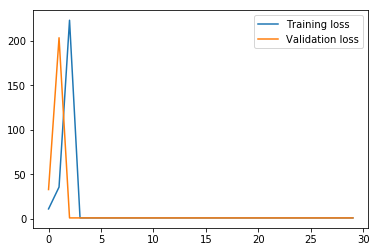

In [137]:
plt.figure()
plt.plot(losslist)
plt.plot(validlosslist)
plt.legend(['Training loss','Validation loss'])
plt.show()

In [140]:
t0 = time.time()
testing = test(all_test_patches[0:100])
print(testing)
test_set_predictions = np.argmax(testing, axis = 1)
t1 = time.time()
print 'Testing time: {} seconds'.format(t1-t0)

print test_set_predictions
print sum(test_set_predictions)

[[ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 [ 0.49716239  0.50283761]
 

In [142]:
outputlayer1 = lasagne.layers.get_output(layer1) 
outputfeatures = theano.function(inputs=[X], outputs=outputlayer1, allow_input_downcast=True) 

features = outputfeatures(all_test_patches[1000:58621])
print np.shape(features)

(57621L, 6L, 28L, 28L)


In [143]:
print features.shape
for i in xrange(6):
    plt.figure()
    plt.imshow(features[1,i],cmap='gray_r',interpolation='none')
    plt.show()

(57621L, 6L, 28L, 28L)
